# 1. Early EDA and Data Cleaning

## 1.1 Imports

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import time

from matplotlib.ticker import MultipleLocator, LinearLocator, AutoMinorLocator
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA

from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import boxcox

## 1.2 Data Understanding

In [ ]:
data = pd.read_csv("https://raw.githubusercontent.com/RizqiSeijuuro/Test-Data-Science/main/EnergyProduction.csv")
data.head()

,DATE,EnergyIndex
0,1970-01-01,43.0869
1,1970-02-01,42.5577
2,1970-03-01,41.6215
3,1970-04-01,40.1982
4,1970-05-01,39.9321


EnergyIndex menunjukkan konsumsi energi per kapita oleh pengguna perumahan, komersial dan industri di suatu kota.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DATE         240 non-null    object 
 1   EnergyIndex  240 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.9+ KB


Dataset terdiri dari 240 baris dan 2 kolom

In [ ]:
 # Convertto datetime format
 
data["DATE"] = pd.to_datetime(data["DATE"])
print("Column 'Date' already has data type", data["DATE"].dtypes)

Column 'Date' already has data type datetime64[ns]


In [ ]:
data.describe()

,EnergyIndex
count,240.000000
mean,56.502198
std,9.043582
min,39.932100
25%,49.799000
50%,55.607250
75%,62.656200
max,84.404000


## 1.3 Checking for Nulls

In [ ]:
data.isnull().sum()

DATE           0
EnergyIndex    0
dtype: int64

## 1.4 Check Duplicated Data

In [ ]:
data[data.duplicated() == True]

,DATE,EnergyIndex


In [ ]:
data[data['DATE'].duplicated() == True]

,DATE,EnergyIndex


## 1.5 Feature Engineering: Date Variable

Change the "Date" feature so that it can be processed.

The Date feature will be separated into 4 columns, namely: <br>
- Date (numeric date) <br>
- Day (day, i.e. Monday, Tuesday, Wednesday, etc.) <br>
- Month (month) <br>
- Year (year) <br>

In [ ]:
# Copy original data into a new DataFrame because we"re going to manipulate it
original_data = data.copy(deep=True)

In [ ]:
# Extract information from Date into columns

data["Day"] = data["DATE"].dt.day # Extract day of month
data["DayOfWeek"] = data["DATE"].dt.weekday # Extract day of week
data["Month"] = data["DATE"].dt.month # Extract month
data["Year"]  = data["DATE"].dt.year # Extract year
data["WeekOfYear"] = data["DATE"].dt.isocalendar().week # Extract week of year

data.head()

,DATE,EnergyIndex,Day,DayOfWeek,Month,Year,WeekOfYear
0,1970-01-01,43.0869,1,3,1,1970,1
1,1970-02-01,42.5577,1,6,2,1970,5
2,1970-03-01,41.6215,1,6,3,1970,9
3,1970-04-01,40.1982,1,2,4,1970,14
4,1970-05-01,39.9321,1,4,5,1970,18


In [ ]:
data["Day"].unique()

array([1])

In [ ]:
data["Year"].unique()

array([1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980,
       1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989])

In [ ]:
original_data

,DATE,EnergyIndex
0,1970-01-01,43.0869
1,1970-02-01,42.5577
2,1970-03-01,41.6215
3,1970-04-01,40.1982
4,1970-05-01,39.9321
...,...,...
235,1989-08-01,75.2704
236,1989-09-01,69.5107
237,1989-10-01,66.0620
238,1989-11-01,69.2555


After being converted into days, it turns out that there is only 1 value, it is 1. This is a natural thing because the day of recording Energy Index is indeed done on the first day in month, it is 1. So we will discard the "Day" column because it only has a single value, which of course will not affect the modeling process.

The "DATE" features will also be dropped because the information has been extracted into separate features.

In [ ]:
# Drop DayofWeek, Date, and DateTime column
data.drop(["Day", "DATE"], axis = 1, inplace = True)
data.head()

,EnergyIndex,DayOfWeek,Month,Year,WeekOfYear
0,43.0869,3,1,1970,1
1,42.5577,6,2,1970,5
2,41.6215,6,3,1970,9
3,40.1982,2,4,1970,14
4,39.9321,4,5,1970,18


## 1.6 Data Distribution

In [ ]:
target = "EnergyIndex"
features = [i for i in data.columns if i not in [target]] #store all features name 
print(features)

['DayOfWeek', 'Month', 'Year', 'WeekOfYear']


In [ ]:
# Separate features into categorical and numerical

categorical_features = []
numerical_features = []
threshold = 100 # This is just an estimation, a categorial feature is likely to have less than 100 unique values

for feature in features:
    if data[feature].nunique() <= threshold:
        categorical_features.append(feature)
    else:
        numerical_features.append(feature)

print("The Dataset has {} numerical & {} categorical features.".format(len(numerical_features),len(categorical_features)))
print("Numerical features are {}".format(numerical_features))
print("Categorical features are {}".format(categorical_features))

The Dataset has 0 numerical & 4 categorical features.
Numerical features are []
Categorical features are ['DayOfWeek', 'Month', 'Year', 'WeekOfYear']


In [ ]:
# Change font size for ticks
def bigger_ticks_font_size(ax):
    ax.tick_params(axis = "x", labelsize = 13)
    ax.tick_params(axis = "y", labelsize = 13)

# Change font size for labels
def bigger_label_font_size(ax, xlabel_name, ylabel_name):
    ax.set_xlabel(xlabel_name, fontsize = 16)
    ax.set_ylabel(ylabel_name, fontsize = 16)

# Create a new color palette consisted of the extracted hex codes from Set2 palette and other additional colors
palette = ["#fc8d62", "#ffd92f", "#e5c494", "#b3b3b3", "#66c2a5", "#96b9d0", "#8da0cb", "#ce94bc", "#eba7ac", "#f5ae52"]

### 1.6.1 Data Distribution: Target

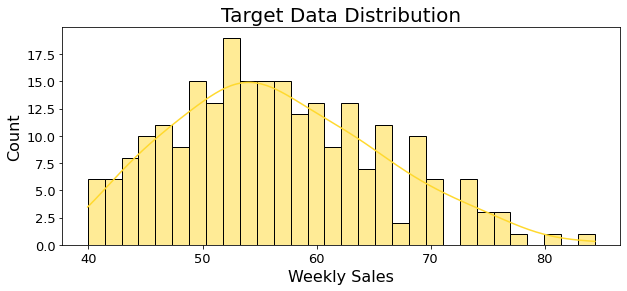

In [ ]:
#plotting label (Weekly Sales) data distribution

plt.figure(figsize=[10,4])
ax = sns.histplot(data[target], color ="#ffd92f", kde = True, bins = 30)

plt.title("Target Data Distribution", fontsize = 20)
bigger_ticks_font_size(ax)
bigger_label_font_size(ax, "Weekly Sales", "Count")

plt.show()

It can be said that the distribution of our target data does have a normal distribution because it tends to be skewed to the right.

### 1.6.3 Data Distribution: Categorical Features

In [ ]:
# Function to plot categorical features using countplot
def countplot_categorical_feature(col_name, title, palette, order = None):
    ax = sns.countplot(x = data[col_name], order = order, palette = palette)
    plt.suptitle("'{}' Feature Distribution".format(title), fontsize = 20)
    #plt.suptitle("Annual Sales during 2010-2012", fontsize = 20)
    bigger_ticks_font_size(ax)
    bigger_label_font_size(ax, title, "Count")

# Function to annotate frequency of each category in barplot
def annotate_barplot (ax, data):
    for p in ax.patches:
        x = p.get_bbox().get_points()[:,0]
        y = p.get_bbox().get_points()[1,1]
        ax.annotate("{:.1f}%".format(100.*y/data), (x.mean(), y), 
            ha = "center", va = "bottom", fontsize = 12) # set the alignment of the text

# Set double axes, count axis is on right, frequency on left
def set_double_axes(ax1, ax2, data, ax1_ax2_xlabel, ax1_ylabel, ax2_ylabel):
    ax2.yaxis.tick_left()
    ax1.yaxis.tick_right()

    # Also switch the labels over
    ax1.yaxis.set_label_position("right")
    ax2.yaxis.set_label_position("left")

    annotate_barplot (ax1, len(data)) #annotate barplot

    # Use a LinearLocator to ensure the correct number of ticks
    ax1.yaxis.set_major_locator(LinearLocator(11))

    # Fix the frequency range to 0-100
    ax2.set_ylim(0,100)
    ax1.set_ylim(0,len(data))

    # And use a MultipleLocator to ensure a tick spacing of 10
    ax2.yaxis.set_major_locator(MultipleLocator(10))

    # Change font size for ticks and label
    bigger_ticks_font_size(ax1)
    bigger_ticks_font_size(ax2)
    bigger_label_font_size(ax1, ax1_ax2_xlabel, ax1_ylabel)
    bigger_label_font_size(ax2, ax1_ax2_xlabel, ax2_ylabel)

    # Need to turn the grid on ax2 off, otherwise the gridlines end up on top of the bars
    ax2.grid(None)

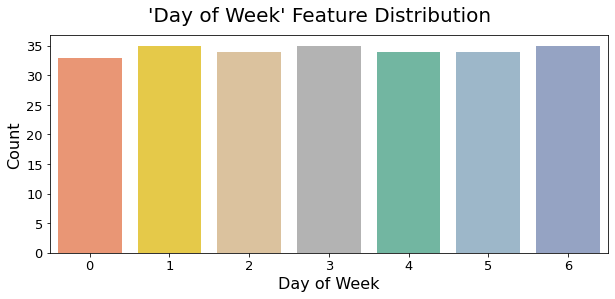

In [ ]:
plt.figure(figsize=(10,4))
countplot_categorical_feature("DayOfWeek", "Day of Week", palette)

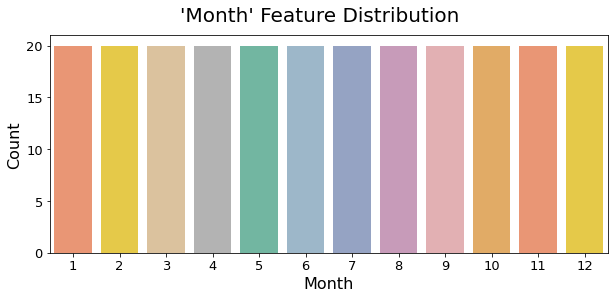

In [ ]:
plt.figure(figsize=(10,4))
countplot_categorical_feature("Month", "Month", palette)

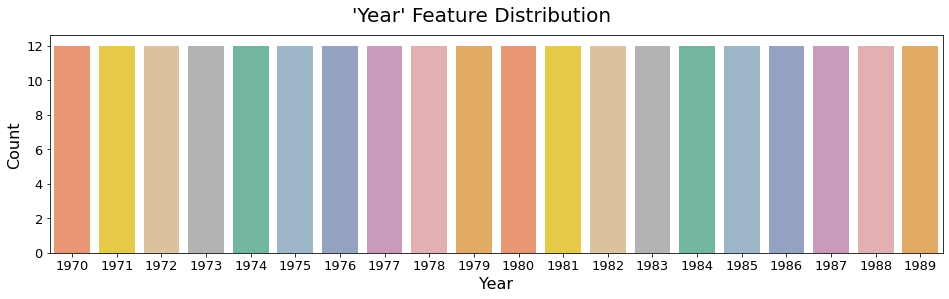

In [ ]:
plt.figure(figsize=(16,4))
countplot_categorical_feature("Year", "Year", palette)

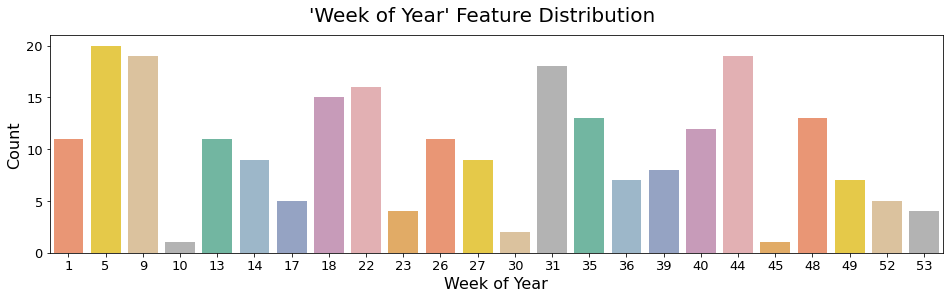

In [ ]:
# Plot "Week of Year" Feature
plt.figure(figsize=(16,4))
countplot_categorical_feature("WeekOfYear", "Week of Year", palette) #order by frequency

## 1.7 Feature Analysis

### 1.7.1 Feature Analysis: Original Datw Feature vs Energy Index

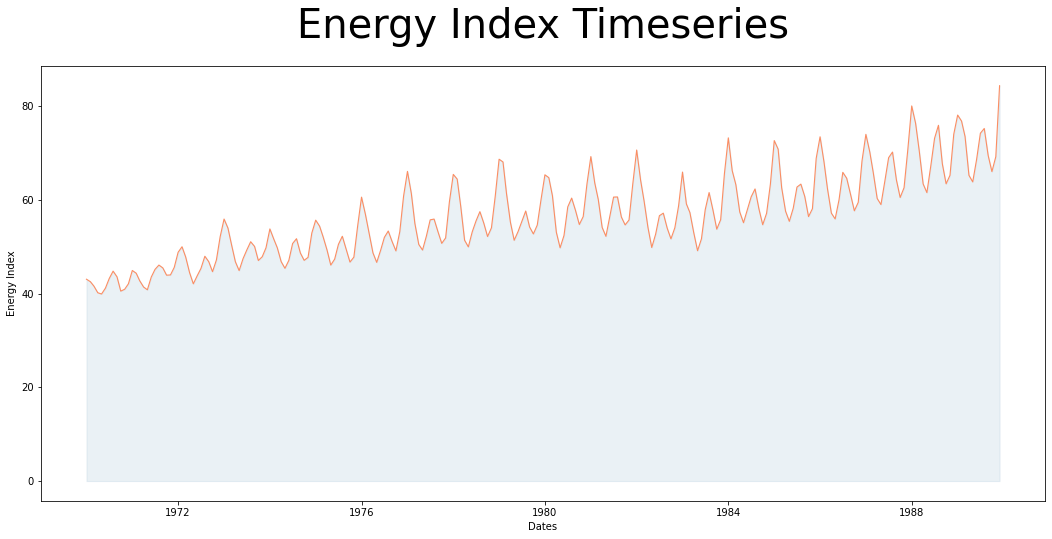

In [ ]:
temp_data = original_data.groupby(['DATE']).sum()
fig, ax = plt.subplots(figsize=(18, 8))

plt.title("Energy Index Timeseries", fontsize=40, y=1.05)
plt.xlabel('Dates')
plt.ylabel('Energy Index')
#list(data['month_year'].astype(str))
ax.fill_between(temp_data.index, temp_data[target], color=palette[5], linewidth=1.1, alpha=0.2)
ax.plot(temp_data.index, temp_data[target], color=palette[0], linewidth=1.1)
# after plotting the data, format the labels
current_values = plt.gca().get_yticks()
# using format string '{:.0f}' here but you can choose others
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
plt.show()

### 1.7.2 Feature Analysis: Day of Week vs Energy Index

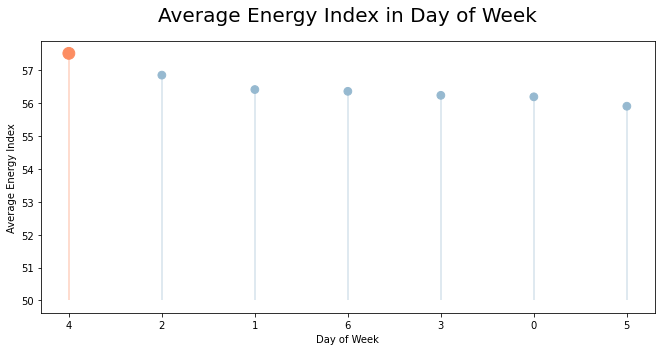

In [ ]:
# Reorder it based on values:
temp_data = data.groupby('DayOfWeek').mean().sort_values(by=target, ascending=False)
temp_data['DayOfWeek'] = temp_data.index.astype(str)
temp_data = temp_data.reset_index(drop=True)

# Create a color if the Sales is Max
my_color=np.where(temp_data[target]==temp_data[target].max(), palette[0], palette[5])
my_size=np.where(temp_data[target]==temp_data[target].max(), 140, 60)
 
# The horizontal plot is made using the vline() function
plt.figure(figsize=(11,5))
plt.vlines(x=temp_data['DayOfWeek'], ymin=50, ymax=temp_data[target], color=my_color, alpha=0.4)
plt.scatter(temp_data['DayOfWeek'], temp_data[target], color=my_color, s=my_size, alpha=1)
 
# Add title and axis names
plt.title("Average Energy Index in Day of Week", fontsize=20, y=1.05)
plt.xlabel('Day of Week')
plt.ylabel('Average Energy Index')
# after plotting the data, format the labels
current_values = plt.gca().get_yticks()
# using format string '{:.0f}' here but you can choose others
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
# show the graph
plt.show()

### 1.7.3 Feature Analysis: Month vs Energy Index

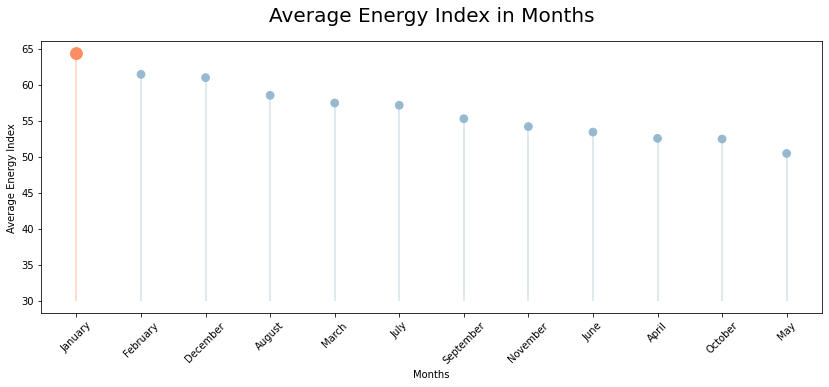

In [ ]:
# Reorder it based on values:
temp_data = data.groupby('Month').mean().sort_values(by=target, ascending=False)
temp_data['Month'] = temp_data.index.astype(str)
temp_data = temp_data.reset_index(drop=True)

# Create a color if the Sales is Max
my_color=np.where(temp_data[target]==temp_data[target].max(), palette[0], palette[5])
my_size=np.where(temp_data[target]==temp_data[target].max(), 140, 60)
 
# The horizontal plot is made using the vline() function
fig, ax = plt.subplots(figsize=(14,5))
plt.vlines(x=temp_data['Month'], ymin=30, ymax=temp_data[target], color=my_color, alpha=0.4)
plt.scatter(temp_data['Month'], temp_data[target], color=my_color, s=my_size, alpha=1)
 
# Add title and axis names
plt.title("Average Energy Index in Months", fontsize=20, y=1.05)
plt.xlabel('Months')
plt.ylabel('Average Energy Index')
fig.canvas.draw()
labels = [item.get_text() for item in ax.get_xticklabels()]
month_name = original_data['DATE'].dt.month_name().unique().astype(str)
for i in range(len(labels)):
  month = int(labels[i])
  labels[i] = str(month_name[month-1])
ax.set_xticklabels(labels, rotation=45)

# after plotting the data, format the labels
current_values = plt.gca().get_yticks()
# using format string '{:.0f}' here but you can choose others
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
# show the graph
plt.show()

### 1.7.4 Feature Analysis: Year vs Energy Index

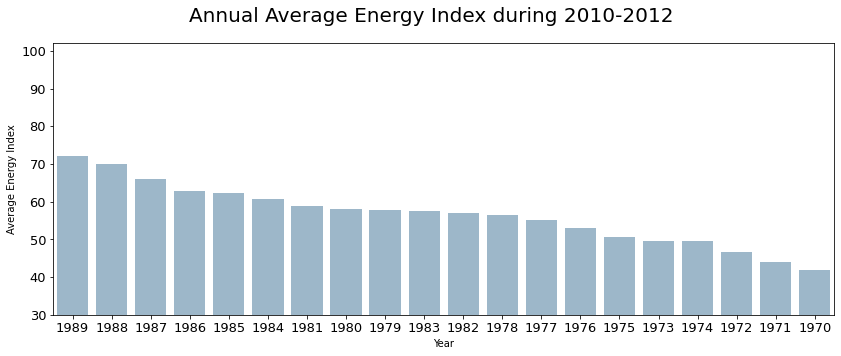

In [ ]:
temp_data = data.groupby('Year').mean().sort_values(by=target, ascending=False)
temp_data['Year'] = temp_data.index.astype(str)
temp_data = temp_data.reset_index(drop=True)

fig, ax = plt.subplots(figsize=(14,5))
ax = sns.barplot(x = temp_data['Year'], y= temp_data[target], palette = [palette[5]])
#plt.suptitle("'{}' Feature Distribution".format(title), fontsize = 20)
ax.set(ylim=(30, temp_data[target].max()+30))
plt.suptitle("Annual Average Energy Index during 2010-2012", fontsize = 20)
bigger_ticks_font_size(ax)
plt.ylabel('Average Energy Index')
# after plotting the data, format the labels
current_values = plt.gca().get_yticks()
# using format string '{:.0f}' here but you can choose others
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
plt.show()

### 1.7.4 Feature Analysis: Week of Year vs Energy Index

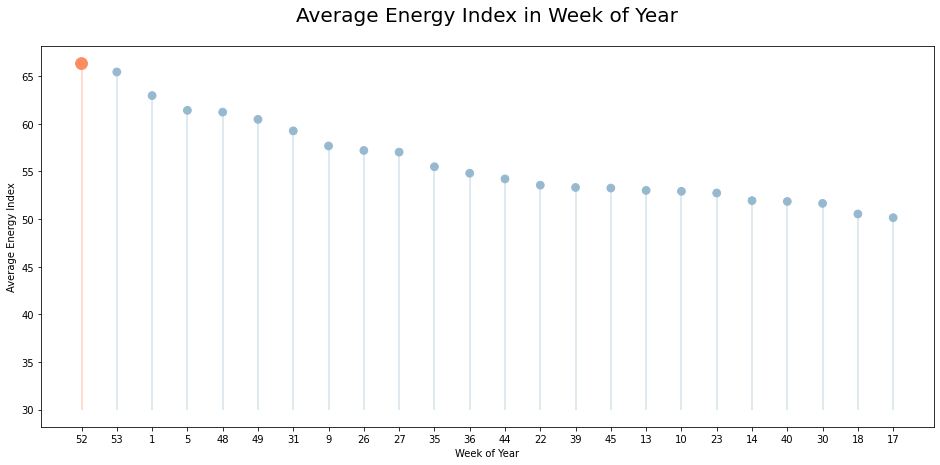

In [ ]:
# Reorder it based on values:
temp_data = data.groupby('WeekOfYear').mean().sort_values(by=target, ascending=False)
temp_data['WeekOfYear'] = temp_data.index.astype(str)
temp_data = temp_data.reset_index(drop=True)

# Create a color if the Sales is Max
my_color=np.where(temp_data[target]==temp_data[target].max(), palette[0], palette[5])
my_size=np.where(temp_data[target]==temp_data[target].max(), 140, 60)
 
# The horizontal plot is made using the vline() function
plt.figure(figsize=(16,7))
plt.vlines(x=temp_data['WeekOfYear'], ymin=30, ymax=temp_data[target], color=my_color, alpha=0.4)
plt.scatter(temp_data['WeekOfYear'], temp_data[target], color=my_color, s=my_size, alpha=1)
 
# Add title and axis names
plt.title("Average Energy Index in Week of Year", fontsize=20, y=1.05)
plt.xlabel('Week of Year')
plt.ylabel('Average Energy Index')
# after plotting the data, format the labels
current_values = plt.gca().get_yticks()
# using format string '{:.0f}' here but you can choose others
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
# show the graph
plt.show()

### 1.7.5 Time series Decomposition

In [ ]:
original_data['DATE'] = pd.to_datetime(original_data['DATE']).dt.to_period('m')
original_data.set_index('DATE', inplace=True)
original_data.index = original_data.index.to_timestamp()

In [ ]:
original_data

,EnergyIndex
DATE,
1970-01-01,43.0869
1970-02-01,42.5577
1970-03-01,41.6215
1970-04-01,40.1982
1970-05-01,39.9321
...,...
1989-08-01,75.2704
1989-09-01,69.5107
1989-10-01,66.0620


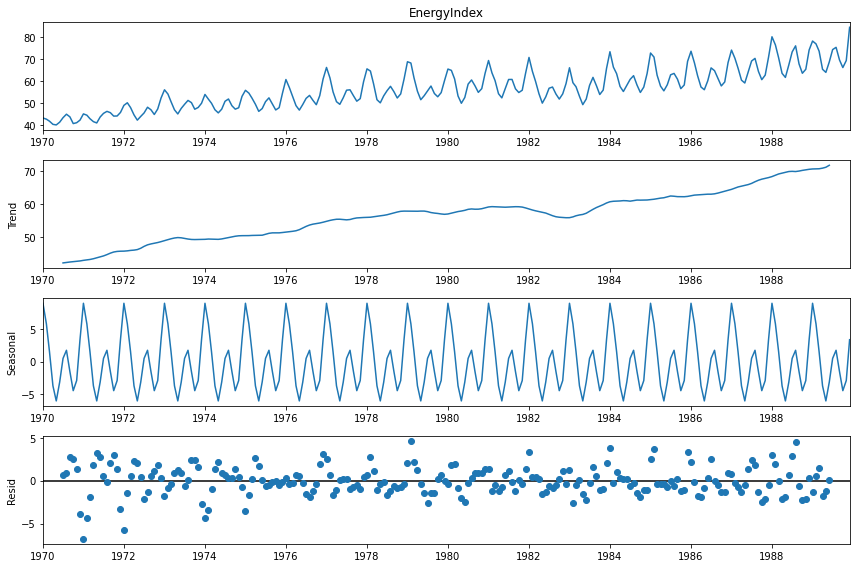

In [ ]:
# Additive seasonal decomposition
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 12, 8
decomposition = sm.tsa.seasonal_decompose(original_data.EnergyIndex, model='additive') # additive seasonal index
fig = decomposition.plot()
plt.show()

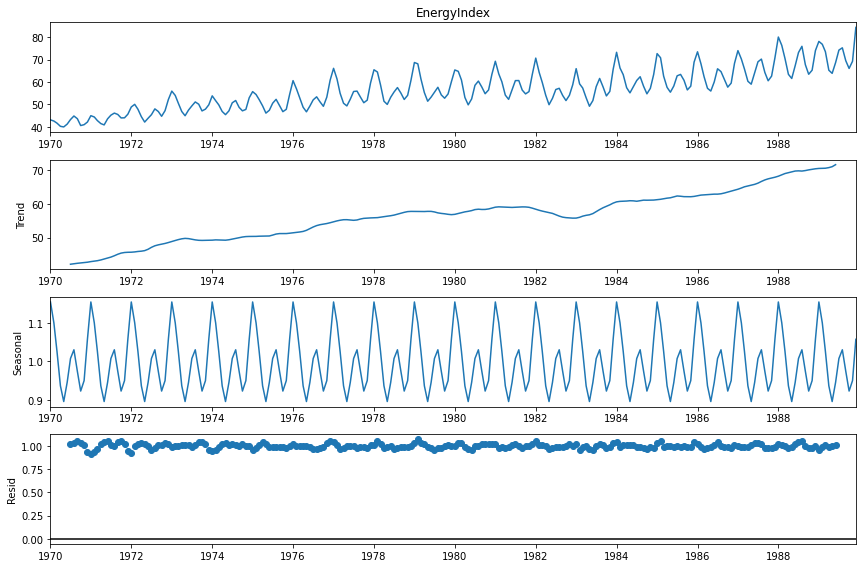

In [ ]:
# Multiplicative seasonal decomposition
decomposition = sm.tsa.seasonal_decompose(original_data.EnergyIndex, model='multiplicative') # multiplicative seasonal index
fig = decomposition.plot()
plt.show()

## 1.8 Check Correlation

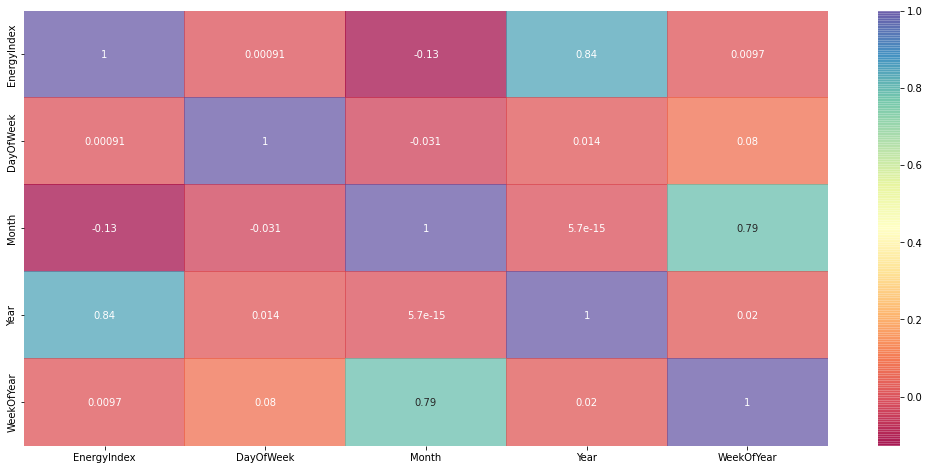

In [ ]:
plt.figure(figsize=(18, 8))
sns.heatmap(data = data.corr(), cmap = "Spectral", annot = True, alpha = 0.7)

## 1.9 Data Encoding

In [ ]:
# Store all column names that we want to encode
cols_to_encode = ["DayOfWeek", "Month", "Year", "WeekOfYear"]

# Create a copy of each dataframe
data_enc = data.copy(deep = True)

# Dummy encoding
for i in cols_to_encode:
    data_enc = pd.concat([data_enc.drop([i], axis=1), pd.DataFrame(pd.get_dummies(data_enc[i], prefix=str(i)))], axis = 1)

In [ ]:
data_enc

,EnergyIndex,DayOfWeek_0,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,Month_1,Month_2,...,WeekOfYear_35,WeekOfYear_36,WeekOfYear_39,WeekOfYear_40,WeekOfYear_44,WeekOfYear_45,WeekOfYear_48,WeekOfYear_49,WeekOfYear_52,WeekOfYear_53
0,43.0869,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,42.5577,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,41.6215,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,40.1982,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,39.9321,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,75.2704,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
236,69.5107,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
237,66.0620,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
238,69.2555,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


# 2. Feature Selection

In [ ]:
data

,EnergyIndex,DayOfWeek,Month,Year,WeekOfYear
0,43.0869,3,1,1970,1
1,42.5577,6,2,1970,5
2,41.6215,6,3,1970,9
3,40.1982,2,4,1970,14
4,39.9321,4,5,1970,18
...,...,...,...,...,...
235,75.2704,1,8,1989,31
236,69.5107,4,9,1989,35
237,66.0620,6,10,1989,39
238,69.2555,2,11,1989,44


In [ ]:
data_enc

,EnergyIndex,DayOfWeek_0,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,Month_1,Month_2,...,WeekOfYear_35,WeekOfYear_36,WeekOfYear_39,WeekOfYear_40,WeekOfYear_44,WeekOfYear_45,WeekOfYear_48,WeekOfYear_49,WeekOfYear_52,WeekOfYear_53
0,43.0869,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,42.5577,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,41.6215,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,40.1982,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,39.9321,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,75.2704,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
236,69.5107,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
237,66.0620,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
238,69.2555,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


## 2.1 Feature Importance

In [ ]:
target = "EnergyIndex"
palette = ["#fc8d62", "#ffd92f", "#e5c494", "#b3b3b3", "#66c2a5", "#96b9d0", "#8da0cb", "#ce94bc", "#eba7ac", "#f5ae52"]
features = [i for i in data_enc.columns if i not in [target]] #store all features name
print("Data target adalah: {}".format(target))
print("Data fitur berjumlah {} dan terdiri dari : {}".format(len(features), features))

Data target adalah: EnergyIndex
Data fitur berjumlah 63 dan terdiri dari : ['DayOfWeek_0', 'DayOfWeek_1', 'DayOfWeek_2', 'DayOfWeek_3', 'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6', 'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12', 'Year_1970', 'Year_1971', 'Year_1972', 'Year_1973', 'Year_1974', 'Year_1975', 'Year_1976', 'Year_1977', 'Year_1978', 'Year_1979', 'Year_1980', 'Year_1981', 'Year_1982', 'Year_1983', 'Year_1984', 'Year_1985', 'Year_1986', 'Year_1987', 'Year_1988', 'Year_1989', 'WeekOfYear_1', 'WeekOfYear_5', 'WeekOfYear_9', 'WeekOfYear_10', 'WeekOfYear_13', 'WeekOfYear_14', 'WeekOfYear_17', 'WeekOfYear_18', 'WeekOfYear_22', 'WeekOfYear_23', 'WeekOfYear_26', 'WeekOfYear_27', 'WeekOfYear_30', 'WeekOfYear_31', 'WeekOfYear_35', 'WeekOfYear_36', 'WeekOfYear_39', 'WeekOfYear_40', 'WeekOfYear_44', 'WeekOfYear_45', 'WeekOfYear_48', 'WeekOfYear_49', 'WeekOfYear_52', 'WeekOfYear_53']


The number of features in the dataset becomes 64 after going through the dummy encoding process. These features are too much to process and not all of them are relevant so we need to do a feature selection first.

One way to look at *feature improtance* is to use the coefficients generated by the regressor (source: [feature importance for linear models -AnalyticsVidhya](https://medium.com/analytics-vidhya/feature-importance-explained-bfc8d874bcf#:~:text=Source-,What%20is%20Feature%20importance%20%3F,both%20classification%20and%20regression%20problem)). Therefore, we will use [RFE (Recursive Feature Elimination)](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html), one of the most popular *feature selection* methods. By using *estimator* which can produce coefficient values (which in this case we use coefficients from the model), RFE will eliminate features recursively based on *feature importance* of each feature.

In [ ]:
# Set features and target values to seperated variables

# Data with outliers
y = data_enc[target]
X = data_enc[features]

# Split train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 42)

In [ ]:
# Dataset with outliers
print("Original dataset :", X.shape, y.shape)
print("Training dataset :", X_train.shape, y_train.shape)
print("Testing dataset  :", X_test.shape,"", y_test.shape)

Original dataset : (240, 63) (240,)
Training dataset : (144, 63) (144,)
Testing dataset  : (96, 63)  (96,)


## 2.2 Feature Ranking using RFE (Recursive Feature Elimination)

To use RFE, we must fill in the parameter n_features_to_select with the number of features we want to select. The problem is, we don't know how many features produce the best *performance*. Therefore, we will loop with all possible number of features, then we will choose the number of features that have the best *performance*.

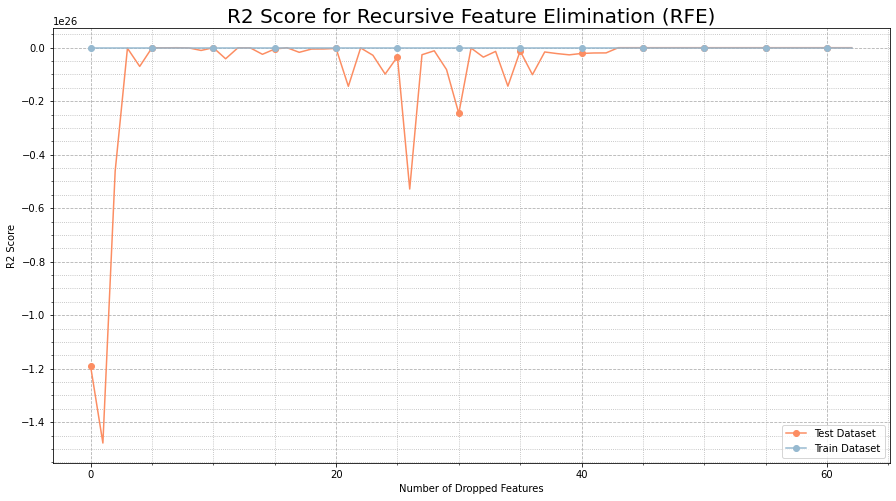

In [ ]:
# Feature Selection with RFE

rfe_train = []
rfe_test = []
# Looping through all the features
for i in range (len(features)):
    # Perform RFE
    rfe           = RFE(estimator = LinearRegression(), n_features_to_select = X_train.shape[1]-i)
    rfe           = rfe.fit(X_train, y_train)
    # Perform regression (Linear Regression here since it's the simplest one) with the selected features
    regressor     = LinearRegression()
    regressor.fit(X_train.loc[:,rfe.support_], y_train)
    # Predict the target values for the both training and testing sets
    y_pred_train  = regressor.predict(X_train.loc[:,rfe.support_])
    y_pred_test   = regressor.predict(X_test.loc[:,rfe.support_])
    # Calculate the r2 score
    r2_train      = r2_score(y_train, y_pred_train)
    r2_test       = r2_score(y_test, y_pred_test)
    # Store the evaluation results
    rfe_train.append(r2_train)
    rfe_test.append(r2_test)

fig, ax = plt.subplots(figsize=(15, 8))
plt.plot(rfe_test, color = palette[0], label = "Test Dataset", marker = 'o', markevery = 5)
plt.plot(rfe_train, color = palette[5], label = "Train Dataset", marker = 'o', markevery = 5)

# Change major ticks to show every 20.
ax.xaxis.set_major_locator(MultipleLocator(20))
# Change minor ticks to show every 5. (20/4 = 5)
ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.yaxis.set_minor_locator(AutoMinorLocator(4))
# Turn grid on for both major and minor ticks.
ax.grid(which = "major", linestyle = "--")
ax.grid(which = "minor", linestyle = ":")
plt.xlabel("Number of Dropped Features")
plt.ylabel("R2 Score")
plt.title ("R2 Score for Recursive Feature Elimination (RFE)", fontsize = 20)
plt.legend()
plt.show()

Based on the RFE graph above, the R2 Score starts to drop drastically when the number of features dropped is >75, which means there are around 76 (151-75) features that have a higher *importance* than other features.

## 2.3 Feature Decomposition using PCA (Principal Component Analysis)

Unlike RFE which will eliminate the feature with the lowest coefficient value, PCA will combine n-component features according to the *variance* value of each feature, so that each feature still has a role in the modeling according to its respective contribution.

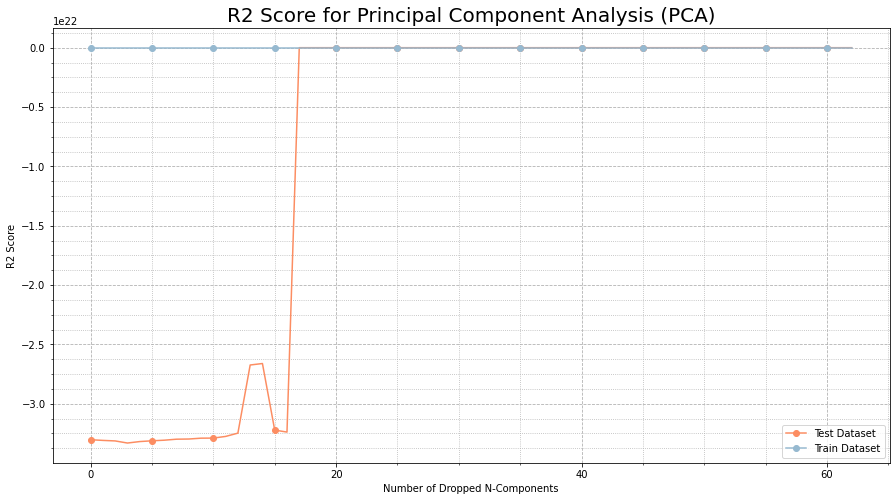

In [ ]:
# Feature Selection with PCA

pca_train = []
pca_test = []
# Looping through all the features
for i in range (len(features)):
    # Perform PCA
    pca           = PCA(n_components = X_train.shape[1]-i)
    X_train_pca   = pca.fit_transform(X_train)
    X_test_pca    = pca.fit_transform(X_test)
    # Predict the target values for the both training and testing sets
    regressor     = LinearRegression()
    regressor.fit(X_train_pca, y_train)
    y_pred_train  = regressor.predict(X_train_pca)
    y_pred_test   = regressor.predict(X_test_pca)
    # Calculate the r2 score
    r2_train      = r2_score(y_train, y_pred_train)
    r2_test       = r2_score(y_test, y_pred_test)
    # Store the evaluation results
    pca_train.append(r2_train)
    pca_test.append(r2_test)

fig, ax = plt.subplots(figsize=(15, 8))
plt.plot(pca_test, color = palette[0], label = "Test Dataset", marker = 'o', markevery = 5)
plt.plot(pca_train, color = palette[5], label = "Train Dataset", marker = 'o', markevery = 5)

# Change major ticks to show every 20.
ax.xaxis.set_major_locator(MultipleLocator(20))
# Change minor ticks to show every 5. (20/4 = 5)
ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.yaxis.set_minor_locator(AutoMinorLocator(4))
# Turn grid on for both major and minor ticks.
ax.grid(which = "major", linestyle = "--")
ax.grid(which = "minor", linestyle = ":")
plt.xlabel("Number of Dropped N-Components")
plt.ylabel("R2 Score")
plt.title ("R2 Score for Principal Component Analysis (PCA)", fontsize = 20)
plt.legend()
plt.show()

It turns out that PCA has a *performance* that tends to be unstable compared to RFE because the R2 Score on the testing dataset fluctuates drastically and irregularly along with the increasing number of N-Components that are dropped so it seems safer to use RFE.

Based on the results of the *feature ranking* above, the highest number features is fine. So we get all feature to modelling

# 3. Modelling & Evaluation

## 3.1 Train Test Split

In [ ]:
# Split train and test dataset
train_len = 216
train = original_data[0 : train_len]
test = original_data[train_len : ]

In [ ]:
train

,EnergyIndex
DATE,
1970-01-01,43.0869
1970-02-01,42.5577
1970-03-01,41.6215
1970-04-01,40.1982
1970-05-01,39.9321
...,...
1987-08-01,70.2369
1987-09-01,64.2987
1987-10-01,60.5402


In [ ]:
test

,EnergyIndex
DATE,
1988-01-01,80.0833
1988-02-01,76.3631
1988-03-01,70.4954
1988-04-01,63.4244
1988-05-01,61.5776
1988-06-01,67.2741
1988-07-01,73.1676
1988-08-01,75.9479
1988-09-01,67.7223


## 3.3 Modelling

## Simple time series methods

### 3.3.1 Naive method

In [ ]:
y_hat_naive = test.copy()
y_hat_naive['naive_forecast'] = train['EnergyIndex'][train_len-1]

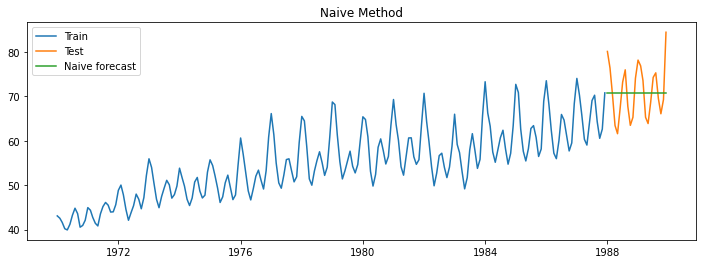

In [ ]:
# Plot train, test and forecast

plt.figure(figsize=(12,4))
plt.plot(train['EnergyIndex'], label='Train')
plt.plot(test['EnergyIndex'], label='Test')
plt.plot(y_hat_naive['naive_forecast'], label='Naive forecast')
plt.legend(loc='best')
plt.title('Naive Method')
plt.show()

In [ ]:
# Calculate RMSE and MAPE

rmse = np.sqrt(mean_squared_error(test['EnergyIndex'], y_hat_naive['naive_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['EnergyIndex']-y_hat_naive['naive_forecast'])/test['EnergyIndex'])*100,2)

results = pd.DataFrame({'Method':['Naive method'], 'MAPE': [mape], 'RMSE': [rmse]})
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,5.88,7.14


### 3.3.2 Simple average method

In [ ]:
y_hat_avg = test.copy()
y_hat_avg['avg_forecast'] = train['EnergyIndex'].mean()

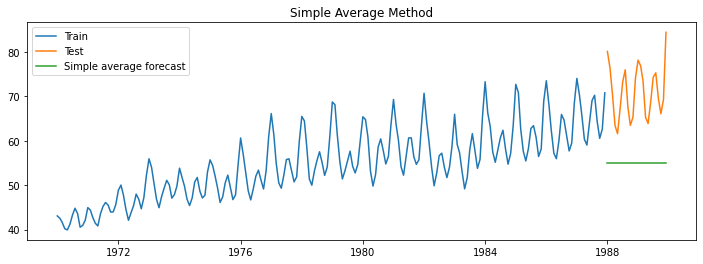

In [ ]:
# Plot train, test and forecast

plt.figure(figsize=(12,4))
plt.plot(train['EnergyIndex'], label='Train')
plt.plot(test['EnergyIndex'], label='Test')
plt.plot(y_hat_avg['avg_forecast'], label='Simple average forecast')
plt.legend(loc='best')
plt.title('Simple Average Method')
plt.show()

In [ ]:
# Calculate RMSE and MAPE

rmse = np.sqrt(mean_squared_error(test['EnergyIndex'], y_hat_avg['avg_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['EnergyIndex']-y_hat_avg['avg_forecast'])/test['EnergyIndex'])*100,2)

tempResults = pd.DataFrame({'Method':['Simple average method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,5.88,7.14
0,Simple average method,17.14,22.16


### 3.3.3 Simple moving average method

In [ ]:
y_hat_sma = original_data.copy()
ma_window = 12
y_hat_sma['sma_forecast'] = original_data['EnergyIndex'].rolling(ma_window).mean()
y_hat_sma['sma_forecast'][train_len:] = y_hat_sma['sma_forecast'][train_len-1]

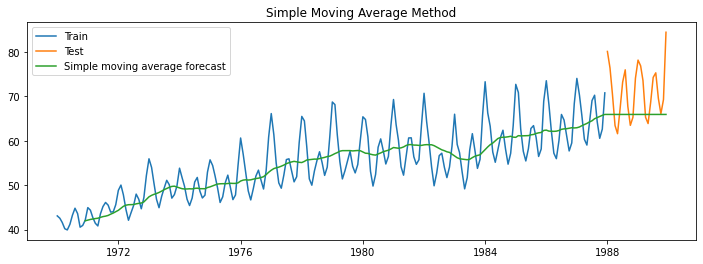

In [ ]:
# Plot train, test and forecast

plt.figure(figsize=(12,4))
plt.plot(train['EnergyIndex'], label='Train')
plt.plot(test['EnergyIndex'], label='Test')
plt.plot(y_hat_sma['sma_forecast'], label='Simple moving average forecast')
plt.legend(loc='best')
plt.title('Simple Moving Average Method')
plt.show()

In [ ]:
# Calculate RMSE and MAPE

rmse = np.sqrt(mean_squared_error(test['EnergyIndex'], y_hat_sma['sma_forecast'][train_len:])).round(2)
mape = np.round(np.mean(np.abs(test['EnergyIndex']-y_hat_sma['sma_forecast'][train_len:])/test['EnergyIndex'])*100,2)

tempResults = pd.DataFrame({'Method':['Simple moving average forecast'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,5.88,7.14
0,Simple average method,17.14,22.16
0,Simple moving average forecast,7.77,8.20


### 3.3.4 Simple exponential smoothing

In [ ]:
model = SimpleExpSmoothing(train['EnergyIndex'])
model_fit = model.fit(optimized=True)
model_fit.params
y_hat_ses = test.copy()
y_hat_ses['ses_forecast'] = model_fit.forecast(len(test))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


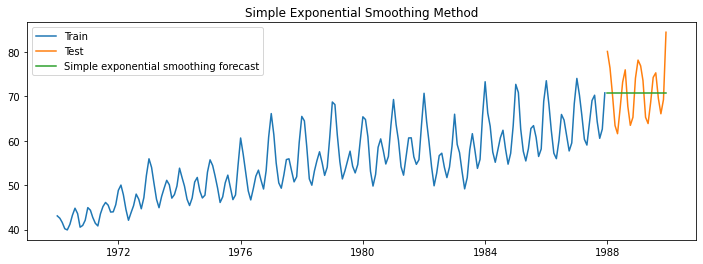

In [ ]:
# Plot train, test, forecast

plt.figure(figsize=(12,4))
plt.plot(train['EnergyIndex'], label='Train')
plt.plot(test['EnergyIndex'], label='Test')
plt.plot(y_hat_ses['ses_forecast'], label='Simple exponential smoothing forecast')
plt.legend(loc='best')
plt.title('Simple Exponential Smoothing Method')
plt.show()

In [ ]:
# Calculate RMSE and MAPE

rmse = np.sqrt(mean_squared_error(test['EnergyIndex'], y_hat_ses['ses_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['EnergyIndex']-y_hat_ses['ses_forecast'])/test['EnergyIndex'])*100,2)

tempResults = pd.DataFrame({'Method':['Simple exponential smoothing forecast'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results

,Method,RMSE,MAPE
0,Naive method,5.88,7.14
0,Simple average method,17.14,22.16
0,Simple moving average forecast,7.77,8.20
0,Simple exponential smoothing forecast,5.88,7.14


### 3.3.5 Holt's method with trend

In [ ]:
model = ExponentialSmoothing(np.asarray(train['EnergyIndex']) ,seasonal_periods=12 ,trend='additive', seasonal=None)
model_fit = model.fit(optimized=True)
print(model_fit.params)
y_hat_holt = test.copy()
y_hat_holt['holt_forecast'] = model_fit.forecast(len(test))

{'smoothing_level': 0.999998928718264, 'smoothing_trend': 2.559901871997204e-08, 'smoothing_seasonal': nan, 'damping_trend': nan, 'initial_level': 42.95815423682805, 'initial_trend': 0.1287441906977843, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


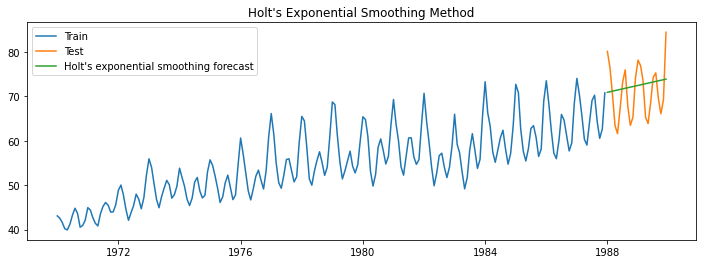

In [ ]:
# Plot train, test, forecast

plt.figure(figsize=(12,4))
plt.plot( train['EnergyIndex'], label='Train')
plt.plot(test['EnergyIndex'], label='Test')
plt.plot(y_hat_holt['holt_forecast'], label='Holt\'s exponential smoothing forecast')
plt.legend(loc='best')
plt.title('Holt\'s Exponential Smoothing Method')
plt.show()

In [ ]:
# Calculate RMSE and MAPE

rmse = np.sqrt(mean_squared_error(test['EnergyIndex'], y_hat_holt['holt_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['EnergyIndex']-y_hat_holt['holt_forecast'])/test['EnergyIndex'])*100,2)

tempResults = pd.DataFrame({'Method':['Holt\'s exponential smoothing method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,5.88,7.14
0,Simple average method,17.14,22.16
0,Simple moving average forecast,7.77,8.20
0,Simple exponential smoothing forecast,5.88,7.14
0,Holt's exponential smoothing method,6.03,7.52


### 3.3.6 Holt Winters' additive method with trend and seasonality

In [ ]:
y_hat_hwa = test.copy()
model = ExponentialSmoothing(np.asarray(train['EnergyIndex']) ,seasonal_periods=12 ,trend='add', seasonal='add')
model_fit = model.fit(optimized=True)
print(model_fit.params)
y_hat_hwa['hw_forecast'] = model_fit.forecast(len(test))

{'smoothing_level': 0.42003445279499607, 'smoothing_trend': 0.0, 'smoothing_seasonal': 0.48528726932469857, 'damping_trend': nan, 'initial_level': 61.24836852143495, 'initial_trend': 0.12163500990344274, 'initial_seasons': array([-18.08510745, -19.58881706, -21.75734096, -23.87571519,
       -24.42966133, -22.4817883 , -20.39257874, -18.61170344,
       -19.24544875, -21.34330158, -20.57799942, -19.19700841]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


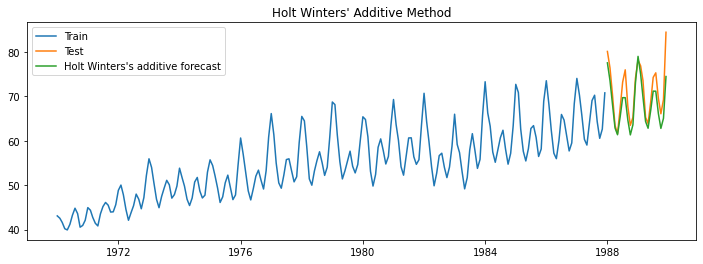

In [ ]:
# Plot train, test, forecast

plt.figure(figsize=(12,4))
plt.plot( train['EnergyIndex'], label='Train')
plt.plot(test['EnergyIndex'], label='Test')
plt.plot(y_hat_hwa['hw_forecast'], label='Holt Winters\'s additive forecast')
plt.legend(loc='best')
plt.title('Holt Winters\' Additive Method')
plt.show()

In [ ]:
# Calculate RMSE and MAPE

rmse = np.sqrt(mean_squared_error(test['EnergyIndex'], y_hat_hwa['hw_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['EnergyIndex']-y_hat_hwa['hw_forecast'])/test['EnergyIndex'])*100,2)

tempResults = pd.DataFrame({'Method':['Holt Winters\' additive method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,5.88,7.14
0,Simple average method,17.14,22.16
0,Simple moving average forecast,7.77,8.20
0,Simple exponential smoothing forecast,5.88,7.14
0,Holt's exponential smoothing method,6.03,7.52
0,Holt Winters' additive method,3.43,3.79


### 3.3.7 Holt Winter's multiplicative method with trend and seasonality

In [ ]:
y_hat_hwm = test.copy()
model = ExponentialSmoothing(np.asarray(train['EnergyIndex']) ,seasonal_periods=12 ,trend='add', seasonal='mul')
model_fit = model.fit(optimized=True)
print(model_fit.params)
y_hat_hwm['hw_forecast'] = model_fit.forecast(len(test))

{'smoothing_level': 0.9999999830057301, 'smoothing_trend': 0.0, 'smoothing_seasonal': 9.584451076464675e-09, 'damping_trend': nan, 'initial_level': 35.69495942698769, 'initial_trend': 0.1320511766374847, 'initial_seasons': array([1.20264423, 1.14074741, 1.06123293, 0.96959578, 0.92679628,
       0.97673419, 1.04182321, 1.06321547, 1.00629905, 0.95338513,
       0.98246397, 1.09886601]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


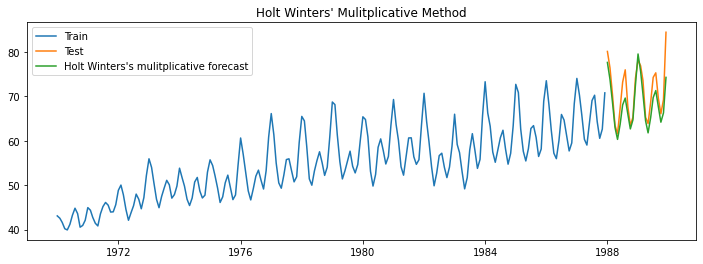

In [ ]:
# Plot train, test, forecast

plt.figure(figsize=(12,4))
plt.plot( train['EnergyIndex'], label='Train')
plt.plot(test['EnergyIndex'], label='Test')
plt.plot(y_hat_hwm['hw_forecast'], label='Holt Winters\'s mulitplicative forecast')
plt.legend(loc='best')
plt.title('Holt Winters\' Mulitplicative Method')
plt.show()

In [ ]:
# Calculate RMSE and MAPE

rmse = np.sqrt(mean_squared_error(test['EnergyIndex'], y_hat_hwm['hw_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['EnergyIndex']-y_hat_hwm['hw_forecast'])/test['EnergyIndex'])*100,2)

tempResults = pd.DataFrame({'Method':['Holt Winters\' multiplicative method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,5.88,7.14
0,Simple average method,17.14,22.16
0,Simple moving average forecast,7.77,8.20
0,Simple exponential smoothing forecast,5.88,7.14
0,Holt's exponential smoothing method,6.03,7.52
0,Holt Winters' additive method,3.43,3.79
0,Holt Winters' multiplicative method,3.47,3.74


## Auto Regressive Method

### Augmented Dickey-Fuller (ADF) test

In [ ]:
adf_test = adfuller(original_data['EnergyIndex'])

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' %adf_test[1])

ADF Statistic: 0.443650
Critical Values @ 0.05: -2.87
p-value: 0.983056


### Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test

In [ ]:
kpss_test = kpss(original_data['EnergyIndex'])

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

KPSS Statistic: 1.497462
Critical Values @ 0.05: 0.46
p-value: 0.010000


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1907: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


Inference : p-value is less than 0.05. This means that the series is not stationary.

To make the series stationary, we need to perform transformation and differencing.

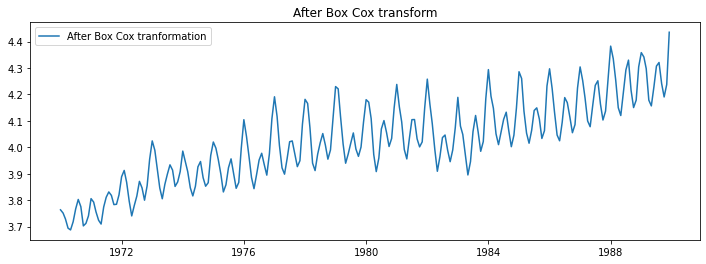

In [ ]:
data_boxcox = pd.Series(boxcox(original_data['EnergyIndex'], lmbda=0), index = original_data.index)

plt.figure(figsize=(12,4))
plt.plot(data_boxcox, label='After Box Cox tranformation')
plt.legend(loc='best')
plt.title('After Box Cox transform')
plt.show()

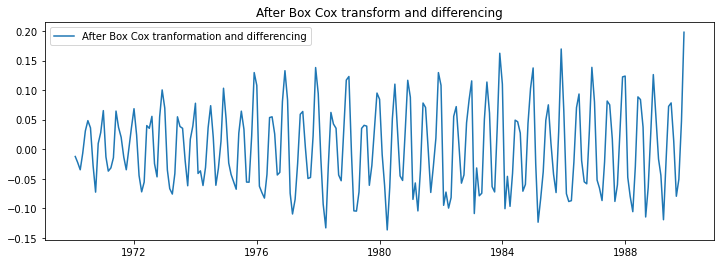

In [ ]:
data_boxcox_diff = pd.Series(data_boxcox - data_boxcox.shift(), original_data.index)
plt.figure(figsize=(12,4))
plt.plot(data_boxcox_diff, label='After Box Cox tranformation and differencing')
plt.legend(loc='best')
plt.title('After Box Cox transform and differencing')
plt.show()

In [ ]:
data_boxcox_diff.dropna(inplace=True) # After shifting the data, drop the first value which is NA

In [ ]:
data_boxcox_diff.tail()

DATE
1989-08-01    0.013661
1989-09-01   -0.079606
1989-10-01   -0.050887
1989-11-01    0.047209
1989-12-01    0.197812
Freq: MS, dtype: float64

### Augmented Dickey-Fuller (ADF) test

In [ ]:
adf_test = adfuller(data_boxcox_diff)

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' %adf_test[1])

ADF Statistic: -5.433723
Critical Values @ 0.05: -2.87
p-value: 0.000003


### Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test

In [ ]:
kpss_test = kpss(data_boxcox_diff)

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

KPSS Statistic: 0.057658
Critical Values @ 0.05: 0.46
p-value: 0.100000


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


In [ ]:
train_data_boxcox = data_boxcox[:train_len]
test_data_boxcox = data_boxcox[train_len:]
train_data_boxcox_diff = data_boxcox_diff[:train_len-1]
test_data_boxcox_diff = data_boxcox_diff[train_len-1:]

### 3.3.8 Auto regression method (AR)

In [ ]:
model = ARIMA(train_data_boxcox_diff, order=(1, 0, 0)) 
model_fit = model.fit()
print(model_fit.params)

const      0.002685
ar.L1.y    0.436643
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [ ]:
# Recover original time series

y_hat_ar = data_boxcox_diff.copy()
y_hat_ar['ar_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox_diff'].cumsum()
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox'].add(data_boxcox[0])
y_hat_ar['ar_forecast'] = np.exp(y_hat_ar['ar_forecast_boxcox'])

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


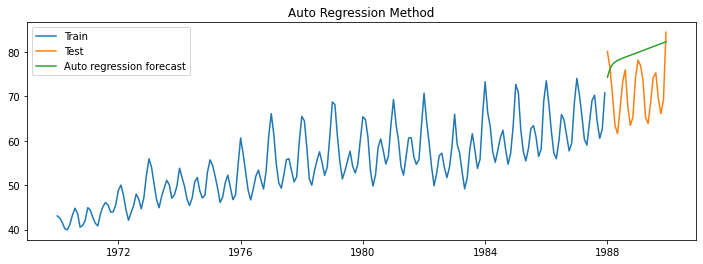

In [ ]:
# Plot train, test and forecast

plt.figure(figsize=(12,4))
plt.plot(train['EnergyIndex'], label='Train')
plt.plot(test['EnergyIndex'], label='Test')
plt.plot(y_hat_ar['ar_forecast'][test.index.min():], label='Auto regression forecast')
plt.legend(loc='best')
plt.title('Auto Regression Method')
plt.show()

In [ ]:
# Calculate RMSE and MAPE

rmse = np.sqrt(mean_squared_error(test['EnergyIndex'], y_hat_ar['ar_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['EnergyIndex']-y_hat_ar['ar_forecast'][test.index.min():])/test['EnergyIndex'])*100,2)

tempResults = pd.DataFrame({'Method':['Autoregressive (AR) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,5.88,7.14
0,Simple average method,17.14,22.16
0,Simple moving average forecast,7.77,8.20
0,Simple exponential smoothing forecast,5.88,7.14
0,Holt's exponential smoothing method,6.03,7.52
0,Holt Winters' additive method,3.43,3.79
0,Holt Winters' multiplicative method,3.47,3.74
0,Autoregressive (AR) method,10.60,13.65


### 3.3.9 Moving average method (MA)

In [ ]:
model = ARIMA(train_data_boxcox_diff, order=(0, 0, 1)) 
model_fit = model.fit()
print(model_fit.params)

const      0.002581
ma.L1.y    0.692277
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [ ]:
# Recover original time series

y_hat_ma = data_boxcox_diff.copy()
y_hat_ma['ma_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox_diff'].cumsum()
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox'].add(data_boxcox[0])
y_hat_ma['ma_forecast'] = np.exp(y_hat_ma['ma_forecast_boxcox'])

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


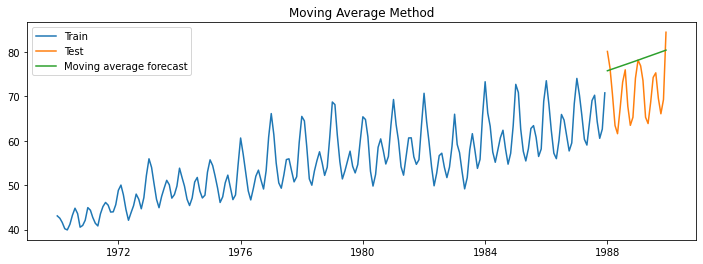

In [ ]:
# Plot train, test and forecast

plt.figure(figsize=(12,4))
plt.plot(original_data['EnergyIndex'][:train_len], label='Train')
plt.plot(original_data['EnergyIndex'][train_len:], label='Test')
plt.plot(y_hat_ma['ma_forecast'][test.index.min():], label='Moving average forecast')
plt.legend(loc='best')
plt.title('Moving Average Method')
plt.show()

In [ ]:
rmse = np.sqrt(mean_squared_error(test['EnergyIndex'], y_hat_ma['ma_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['EnergyIndex']-y_hat_ma['ma_forecast'][test.index.min():])/test['EnergyIndex'])*100,2)

tempResults = pd.DataFrame({'Method':['Moving Average (MA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,5.88,7.14
0,Simple average method,17.14,22.16
0,Simple moving average forecast,7.77,8.20
0,Simple exponential smoothing forecast,5.88,7.14
0,Holt's exponential smoothing method,6.03,7.52
0,Holt Winters' additive method,3.43,3.79
0,Holt Winters' multiplicative method,3.47,3.74
0,Autoregressive (AR) method,10.60,13.65
0,Moving Average (MA) method,9.20,11.55


### 3.3.10 Auto regression moving average method (ARMA)

In [ ]:
model = ARIMA(train_data_boxcox_diff, order=(1, 0, 1))
model_fit = model.fit()
print(model_fit.params)

const      0.002655
ar.L1.y    0.126823
ma.L1.y    0.629809
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [ ]:
# Recover original time series

y_hat_arma = data_boxcox_diff.copy()
y_hat_arma['arma_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_arma['arma_forecast_boxcox'] = y_hat_arma['arma_forecast_boxcox_diff'].cumsum()
y_hat_arma['arma_forecast_boxcox'] = y_hat_arma['arma_forecast_boxcox'].add(data_boxcox[0])
y_hat_arma['arma_forecast'] = np.exp(y_hat_arma['arma_forecast_boxcox'])

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


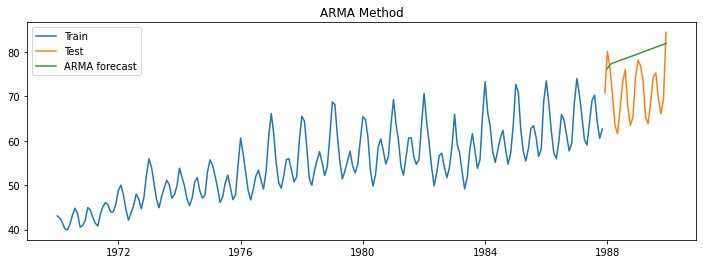

In [ ]:
# Plot train, test and forecast

plt.figure(figsize=(12,4))
plt.plot( original_data['EnergyIndex'][:train_len-1], label='Train')
plt.plot(original_data['EnergyIndex'][train_len-1:], label='Test')
plt.plot(y_hat_arma['arma_forecast'][test.index.min():], label='ARMA forecast')
plt.legend(loc='best')
plt.title('ARMA Method')
plt.show()

In [ ]:
# Calculate RMSE and MAPE

rmse = np.sqrt(mean_squared_error(test['EnergyIndex'], y_hat_arma['arma_forecast'][train_len-1:])).round(2)
mape = np.round(np.mean(np.abs(test['EnergyIndex']-y_hat_arma['arma_forecast'][train_len-1:])/test['EnergyIndex'])*100,2)

tempResults = pd.DataFrame({'Method':['Autoregressive moving average (ARMA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,5.88,7.14
0,Simple average method,17.14,22.16
0,Simple moving average forecast,7.77,8.20
0,Simple exponential smoothing forecast,5.88,7.14
0,Holt's exponential smoothing method,6.03,7.52
0,Holt Winters' additive method,3.43,3.79
0,Holt Winters' multiplicative method,3.47,3.74
0,Autoregressive (AR) method,10.60,13.65
0,Moving Average (MA) method,9.20,11.55
0,Autoregressive moving average (ARMA) method,10.33,13.25


### 3.3.11 Auto regressive integrated moving average (ARIMA)

In [ ]:
model = ARIMA(train_data_boxcox, order=(1, 1, 1))
model_fit = model.fit()
print(model_fit.params)

const        0.002655
ar.L1.D.y    0.126823
ma.L1.D.y    0.629809
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [ ]:
# Recover original time series forecast

y_hat_arima = data_boxcox_diff.copy()
y_hat_arima['arima_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox_diff'].cumsum()
y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox'].add(data_boxcox[0])
y_hat_arima['arima_forecast'] = np.exp(y_hat_arima['arima_forecast_boxcox'])

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


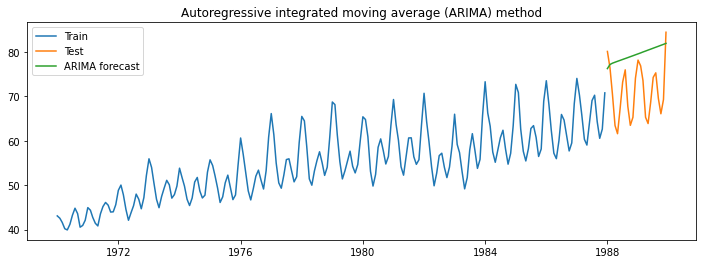

In [ ]:
# Plot train, test and forecast

plt.figure(figsize=(12,4))
plt.plot(train['EnergyIndex'], label='Train')
plt.plot(test['EnergyIndex'], label='Test')
plt.plot(y_hat_arima['arima_forecast'][test.index.min():], label='ARIMA forecast')
plt.legend(loc='best')
plt.title('Autoregressive integrated moving average (ARIMA) method')
plt.show()

In [ ]:
# Calculate RMSE and MAPE

rmse = np.sqrt(mean_squared_error(test['EnergyIndex'], y_hat_arima['arima_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['EnergyIndex']-y_hat_arima['arima_forecast'][test.index.min():])/test['EnergyIndex'])*100,2)

tempResults = pd.DataFrame({'Method':['Autoregressive integrated moving average (ARIMA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,5.88,7.14
0,Simple average method,17.14,22.16
0,Simple moving average forecast,7.77,8.20
0,Simple exponential smoothing forecast,5.88,7.14
0,Holt's exponential smoothing method,6.03,7.52
0,Holt Winters' additive method,3.43,3.79
0,Holt Winters' multiplicative method,3.47,3.74
0,Autoregressive (AR) method,10.60,13.65
0,Moving Average (MA) method,9.20,11.55
0,Autoregressive moving average (ARMA) method,10.33,13.25


### 3.3.12 Seasonal auto regressive integrated moving average (SARIMA)

In [ ]:
model = SARIMAX(train_data_boxcox, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)) 
model_fit = model.fit()
print(model_fit.params)

ar.L1       0.705276
ma.L1      -0.896162
ar.S.L12    0.120702
ma.S.L12   -0.679907
sigma2      0.000566
dtype: float64


In [ ]:
# Recover original time series forecast

y_hat_sarima = data_boxcox_diff.copy()
y_hat_sarima['sarima_forecast_boxcox'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_sarima['sarima_forecast'] = np.exp(y_hat_sarima['sarima_forecast_boxcox'])

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


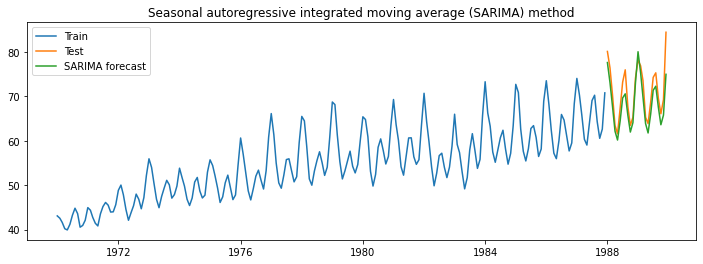

In [ ]:
# Plot train, test and forecast

plt.figure(figsize=(12,4))
plt.plot(train['EnergyIndex'], label='Train')
plt.plot(test['EnergyIndex'], label='Test')
plt.plot(y_hat_sarima['sarima_forecast'][test.index.min():], label='SARIMA forecast')
plt.legend(loc='best')
plt.title('Seasonal autoregressive integrated moving average (SARIMA) method')
plt.show()

In [ ]:
# Calculate RMSE and MAPE

rmse = np.sqrt(mean_squared_error(test['EnergyIndex'], y_hat_sarima['sarima_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['EnergyIndex']-y_hat_sarima['sarima_forecast'][test.index.min():])/test['EnergyIndex'])*100,2)

tempResults = pd.DataFrame({'Method':['Seasonal autoregressive integrated moving average (SARIMA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,5.88,7.14
0,Simple average method,17.14,22.16
0,Simple moving average forecast,7.77,8.20
0,Simple exponential smoothing forecast,5.88,7.14
0,Holt's exponential smoothing method,6.03,7.52
0,Holt Winters' additive method,3.43,3.79
0,Holt Winters' multiplicative method,3.47,3.74
0,Autoregressive (AR) method,10.60,13.65
0,Moving Average (MA) method,9.20,11.55
0,Autoregressive moving average (ARMA) method,10.33,13.25


## 3.4 Best Model

In [ ]:
final_result = results.sort_values(["RMSE","MAPE"])[:3]
final_result

,Method,RMSE,MAPE
0,Seasonal autoregressive integrated moving aver...,3.22,3.75
0,Holt Winters' additive method,3.43,3.79
0,Holt Winters' multiplicative method,3.47,3.74
